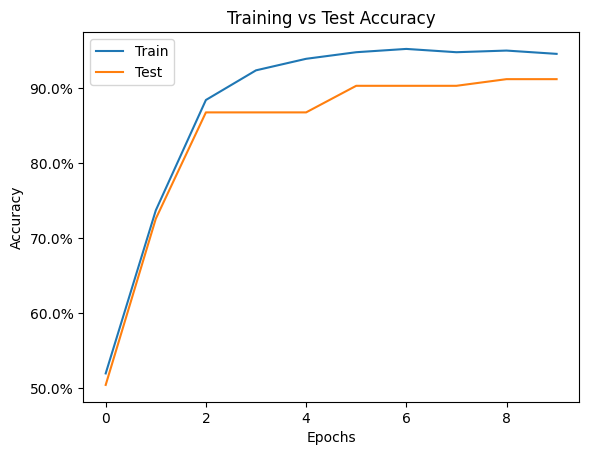

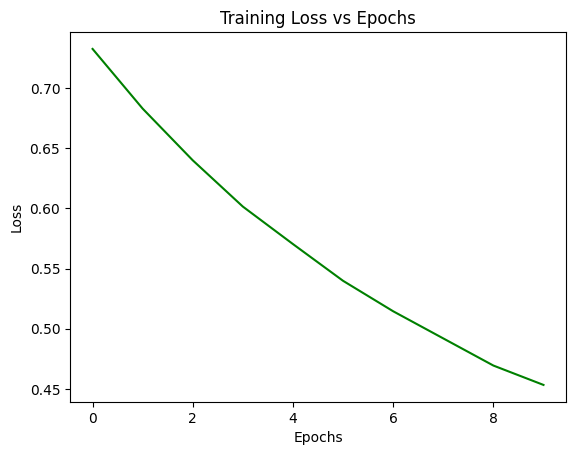

Final Train Accuracy: 94.52%
Final Test Accuracy: 91.15%


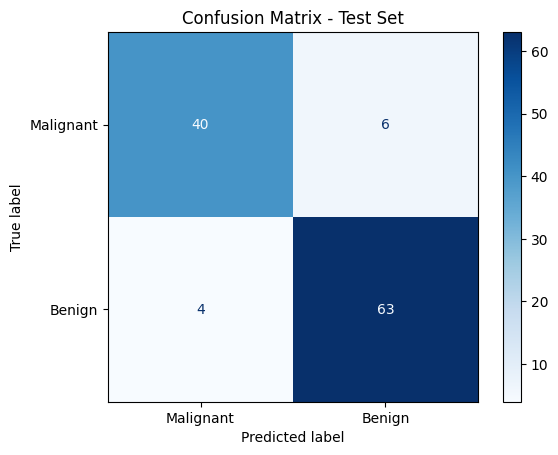

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ----------------------------
# Load dataset
# ----------------------------
data = load_breast_cancer()
X, y = data.data, data.target

# ----------------------------
# Custom Dataset
# ----------------------------
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

dataset = CustomDataset(X, y)

# ----------------------------
# Split train/test
# ----------------------------
test_size = int(0.2 * len(dataset))
train_set, test_set = random_split(
    dataset, [len(dataset) - test_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# ----------------------------
# Normalize dataset
# ----------------------------
train_x = dataset.x[train_set.indices]
mean = train_x.mean(dim=0)
std = train_x.std(dim=0)
dataset.x = (dataset.x - mean) / std

# ----------------------------
# DataLoader
# ----------------------------
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

# ----------------------------
# Define Neural Network
# ----------------------------
input_dim = X.shape[1]
hidden_dim = 1000

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1),
    nn.Sigmoid()
)

# ----------------------------
# Evaluation function
# ----------------------------
def evaluate(model, train_loader, test_loader):
    acc_train, acc_test = 0.0, 0.0  # assicurati che siano float
    with torch.no_grad():
        for x_train, y_train in train_loader:
            out = model(x_train).squeeze()
            acc_train += (out.round() == y_train).float().sum()  # converti a float
        for x_test, y_test in test_loader:
            out = model(x_test).squeeze()
            acc_test += (out.round() == y_test).float().sum()   # converti a float
    acc_train /= len(train_loader.dataset)
    acc_test /= len(test_loader.dataset)
    return acc_train * 100, acc_test * 100
# ----------------------------
# Training
# ----------------------------
EPOCHS = 10
learning_rate = 0.002

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, test_accuracies = [], [], []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for x_train, y_train in train_loader:
        out = model(x_train).squeeze()
        loss = loss_function(out, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    train_losses.append(epoch_loss.detach()/len(train_loader))
    train_acc, test_acc = evaluate(model, train_loader, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# ----------------------------
# Plot Training vs Test Accuracy
# ----------------------------
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Training vs Test Accuracy")
plt.legend()
plt.show()

# ----------------------------
# Plot Training Loss
# ----------------------------
plt.plot(train_losses, color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.show()

# ----------------------------
# Print Final Accuracies
# ----------------------------
final_train_acc, final_test_acc = evaluate(model, train_loader, test_loader)
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

# ----------------------------
# Confusion Matrix on Test Set
# ----------------------------
all_test_x, all_test_y = next(iter(test_loader))
preds = model(all_test_x).squeeze().round().detach()

cm = confusion_matrix(all_test_y.numpy(), preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Malignant", "Benign"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()
